# IMPORTS

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from pycaret.classification import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

## LEITURA DOS DADOS

In [27]:
df = pd.read_csv('../RawData/train_radiomics_hipocamp.csv') 
df_test = pd.read_csv('../RawData/test_radiomics_hipocamp.csv')

# Tratamento

### Single Value Colums 

In [28]:
df = df.loc[:, df.nunique() > 1]
df_test = df_test.loc[:, df_test.nunique() > 1]


#  Analise das colunas que tem menos de 50 valores unicos 
n = df.nunique()
for col, e in n.items():
    if e < 50:  
        print(f"Coluna: {col}, Valores Unicos : {e}")

Coluna: original_firstorder_10Percentile, Valores Unicos : 31
Coluna: original_firstorder_90Percentile, Valores Unicos : 13
Coluna: original_firstorder_InterquartileRange, Valores Unicos : 13
Coluna: original_firstorder_Maximum, Valores Unicos : 29
Coluna: original_firstorder_Median, Valores Unicos : 15
Coluna: original_firstorder_Minimum, Valores Unicos : 30
Coluna: original_firstorder_Range, Valores Unicos : 45
Coluna: wavelet-HHH_glszm_GrayLevelNonUniformityNormalized, Valores Unicos : 33
Coluna: wavelet-HHH_glszm_GrayLevelVariance, Valores Unicos : 34
Coluna: gradient_firstorder_Minimum, Valores Unicos : 3
Coluna: lbp-2D_firstorder_10Percentile, Valores Unicos : 4
Coluna: lbp-2D_firstorder_90Percentile, Valores Unicos : 2
Coluna: lbp-2D_firstorder_InterquartileRange, Valores Unicos : 3
Coluna: lbp-2D_firstorder_Median, Valores Unicos : 2
Coluna: lbp-3D-m1_firstorder_10Percentile, Valores Unicos : 10
Coluna: lbp-3D-m1_firstorder_90Percentile, Valores Unicos : 12
Coluna: lbp-3D-m1_fi

### AGE BINING  ( secalhar isto era no 2 )

In [29]:

age_bins = [0, 65, 75, 85, 100]
# BINS_SIZER = ['<65', '65-74', '75-84', '85+']
age_labels = [60, 70, 80, 90] # VALOR MEDIO DO BIN 
df['Age'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels).astype(int)
df_test['Age'] = pd.cut(df_test['Age'], bins=age_bins, labels=age_labels).astype(int)

print(df['Age'])

0      80
1      80
2      80
3      80
4      80
       ..
300    70
301    70
302    80
303    60
304    70
Name: Age, Length: 305, dtype: int64


### Colunas Categoricas 

In [30]:
# Analisar a contagem de valores únicos para cada coluna categórica

# Identificar as colunas categóricas
categorical_columns = df.select_dtypes(include=['object', 'category']).columns

for col in categorical_columns:
    print(f"\nColuna: {col}")

#colunas_catagoricas_a_remover = ['ID', 'Image', 'Mask', 'diagnostics_Image-original_Hash', 'diagnostics_Mask-original_Hash'] 

colunas_catagoricas_a_remover = ['ID', 'Image', 'Mask', 'diagnostics_Image-original_Hash', 'diagnostics_Mask-original_Hash', 'diagnostics_Mask-original_BoundingBox', 'diagnostics_Mask-original_CenterOfMassIndex', 'diagnostics_Mask-original_CenterOfMass'] 

# ** Bounding Box
#
# ** as colunas do 'diagnostics_Mask-original_BoundingBox', 'diagnostics_Mask-original_CenterOfMassIndex', 'diagnostics_Mask-original_CenterOfMass'
# ** Deveriam ser retiradas, mas o bounding box pode ser importante para a zona de maior ativação do Alzimeir 
# **  ja a de centro de maxima devem ser muito correlacionados, por isso devem ser retirados mais para a frente 
# *TODO acabei por retirar para correr melhor os modelos, mas analisar se se deve retirar ou nao 

df.drop(columns=colunas_catagoricas_a_remover,axis= 1 , inplace= True)
df_test.drop(columns=colunas_catagoricas_a_remover,axis= 1 , inplace= True)


Coluna: ID

Coluna: Image

Coluna: Mask

Coluna: diagnostics_Image-original_Hash

Coluna: diagnostics_Mask-original_Hash

Coluna: diagnostics_Mask-original_BoundingBox

Coluna: diagnostics_Mask-original_CenterOfMassIndex

Coluna: diagnostics_Mask-original_CenterOfMass

Coluna: Transition


### Eliminar Transition CN-MCI 

Como este tipo de precisao não vai ser realiza, decidimos retirar todas as linhas com ela relacinadas para nao confundir o nosso modelo

In [31]:
df = df[df['Transition'] != 'CN-MCI']

### Label Encoding

In [32]:
label_mapping = {
    'CN-CN': 0,
    'AD-AD': 1,
    'MCI-AD': 2,
    'MCI-MCI': 3
}
# Apply the mapping to the target column
df['Transition'] = df['Transition'].map(label_mapping)

## Models

In [33]:

experiment = setup(df, target='Transition')

,Description,Value
0,Session id,6337
1,Target,Transition
2,Target type,Multiclass
3,Original data shape,"(295, 2014)"
4,Transformed data shape,"(295, 2014)"
5,Transformed train set shape,"(206, 2014)"
6,Transformed test set shape,"(89, 2014)"
7,Numeric features,2013
8,Preprocess,True
9,Imputation type,simple


In [34]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.4564,0.7283,0.4564,0.4128,0.4154,0.2555,0.2668,0.0980
et,Extra Trees Classifier,0.4510,0.7316,0.4510,0.4069,0.4012,0.2441,0.2596,0.0930
knn,K Neighbors Classifier,0.4414,0.6573,0.4414,0.4240,0.4117,0.2398,0.2494,0.1750
xgboost,Extreme Gradient Boosting,0.4262,0.7023,0.4262,0.4369,0.4041,0.2170,0.2273,2.4260
gbc,Gradient Boosting Classifier,0.4221,0.0000,0.4221,0.4235,0.4023,0.2149,0.2225,4.0800
lightgbm,Light Gradient Boosting Machine,0.4167,0.6843,0.4167,0.4012,0.3922,0.2037,0.2126,2.4380
nb,Naive Bayes,0.4162,0.7143,0.4162,0.4135,0.3962,0.2145,0.2214,0.0740
lda,Linear Discriminant Analysis,0.3890,0.0000,0.3890,0.3871,0.3759,0.1786,0.1836,0.0840
lr,Logistic Regression,0.3743,0.0000,0.3743,0.3960,0.3685,0.1588,0.1632,0.8890
ada,Ada Boost Classifier,0.3438,0.0000,0.3438,0.3705,0.3333,0.1177,0.1222,0.2830


Com o tratamento atual, o pycaret diz que os melhores modelos são :
- Random Forest Classifier
- Extra Trees Classifier
- Gradient Boosting Classifier 
- K Neighbors Classifier
- Extreme Gradient Boosting 


### Aplicação dos modelos (default) ao dataset tratado

In [35]:
X = df.drop('Transition', axis=1)
y = df['Transition']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2022)



In [36]:
def plot_confusion_matrix_with_labels(confusion_matrix, label_mapping):
    # Criar um mapeamento inverso
    reverse_label_mapping = {v: k for k, v in label_mapping.items()}
    
    # Aplicar o mapeamento inverso na matriz de confusão
    cm_with_labels = np.zeros_like(confusion_matrix, dtype=object)
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            cm_with_labels[i, j] = f"{reverse_label_mapping[i]} (Pred: {reverse_label_mapping[j]})"

    # Criar um DataFrame para facilitar a visualização
    df_cm = pd.DataFrame(confusion_matrix, index=reverse_label_mapping.values(), columns=reverse_label_mapping.values())
    
    # Plotar a matriz de confusão
    plt.figure(figsize=(10, 7))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix with Labels')
    plt.show()

#### Random Forest Classifier

              precision    recall  f1-score   support

           0       0.57      0.91      0.70        22
           1       0.44      0.50      0.47        16
           2       0.40      0.22      0.29        18
           3       0.27      0.17      0.21        18

    accuracy                           0.47        74
   macro avg       0.42      0.45      0.42        74
weighted avg       0.43      0.47      0.43        74



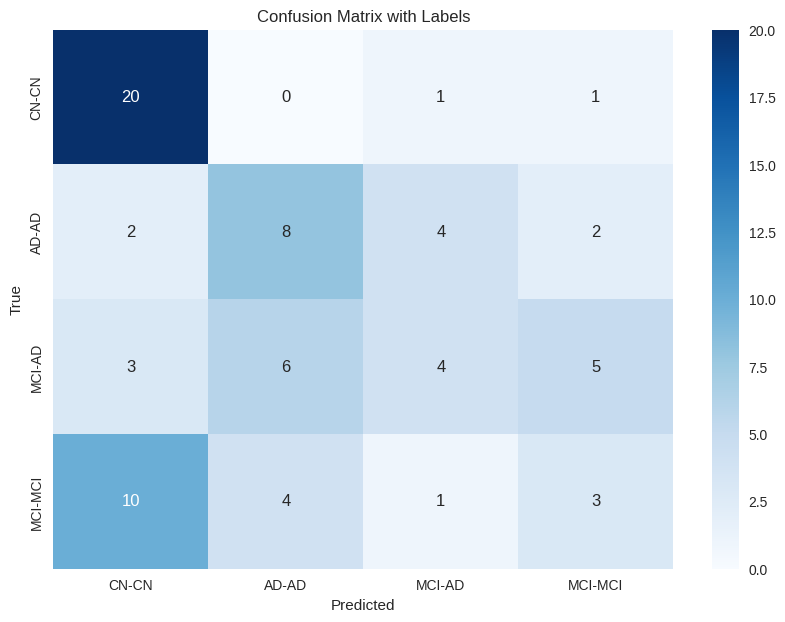

In [37]:

rf_model = RandomForestClassifier(n_estimators=100, max_features='sqrt', random_state=2022)

rf_model.fit(X_train, y_train)


rf_pred = rf_model.predict(X_test)
print(classification_report(y_test, rf_pred))
cm = confusion_matrix(y_test, rf_pred)
plot_confusion_matrix_with_labels(cm,label_mapping)




#### Extra Trees Classifier

              precision    recall  f1-score   support

           0       0.60      0.95      0.74        22
           1       0.47      0.44      0.45        16
           2       0.29      0.22      0.25        18
           3       0.40      0.22      0.29        18

    accuracy                           0.49        74
   macro avg       0.44      0.46      0.43        74
weighted avg       0.45      0.49      0.45        74



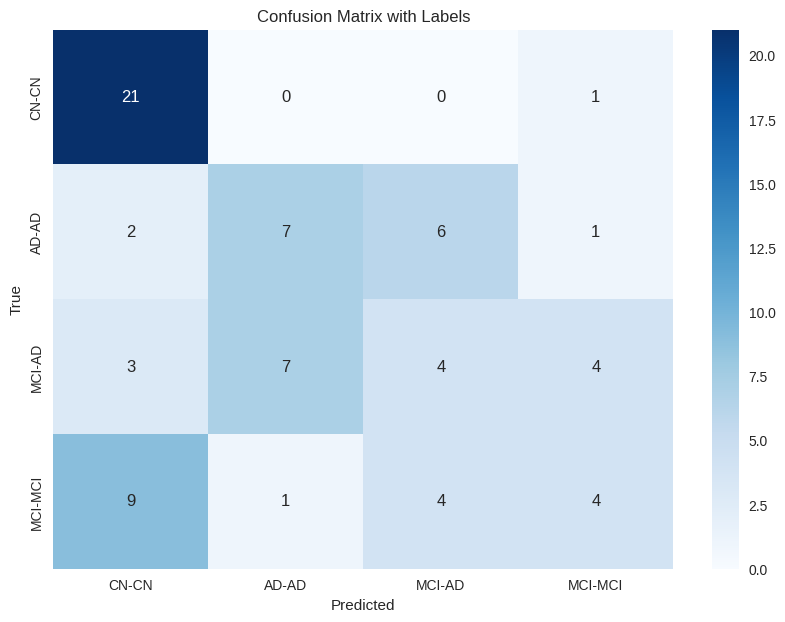

0.4864864864864865


In [38]:
et_model = ExtraTreesClassifier(criterion='gini', max_depth=20, random_state=2022)
et_model.fit(X_train, y_train)
et_pred = et_model.predict(X_test)
print(classification_report(y_test,et_pred))
cm = confusion_matrix(y_test,et_pred)
plot_confusion_matrix_with_labels(cm, label_mapping)
plt.show
print(accuracy_score(y_test, et_pred))

#### Gradient Boosting Classifier 

              precision    recall  f1-score   support

           0       0.56      0.82      0.67        22
           1       0.50      0.31      0.38        16
           2       0.25      0.22      0.24        18
           3       0.25      0.22      0.24        18

    accuracy                           0.42        74
   macro avg       0.39      0.39      0.38        74
weighted avg       0.40      0.42      0.40        74



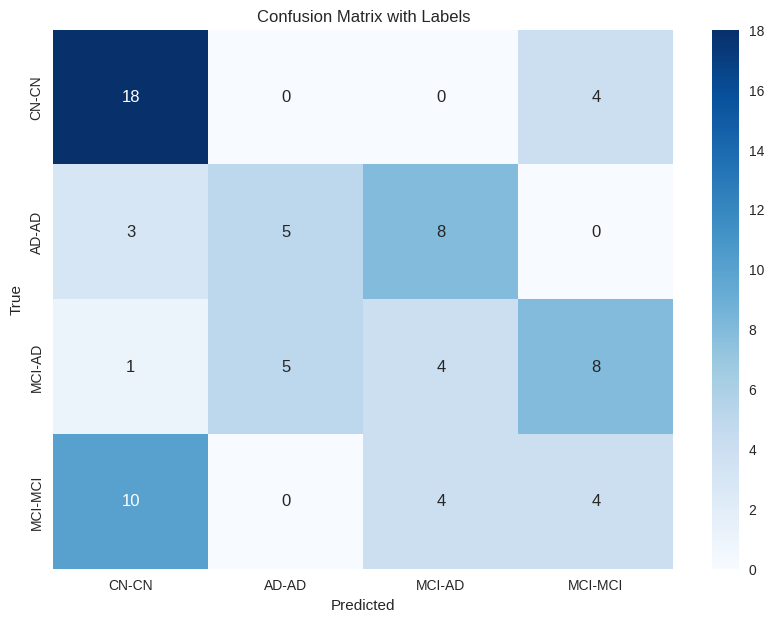

0.4189189189189189


In [39]:
gb_model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)
print(classification_report(y_test,gb_pred))
cm = confusion_matrix(y_test,gb_pred)
plot_confusion_matrix_with_labels(cm,label_mapping)
plt.show
print(accuracy_score(y_test, gb_pred))

#### K Neighbors Classifier

              precision    recall  f1-score   support

           0       0.45      0.77      0.57        22
           1       0.50      0.38      0.43        16
           2       0.53      0.44      0.48        18
           3       0.22      0.11      0.15        18

    accuracy                           0.45        74
   macro avg       0.43      0.43      0.41        74
weighted avg       0.42      0.45      0.42        74



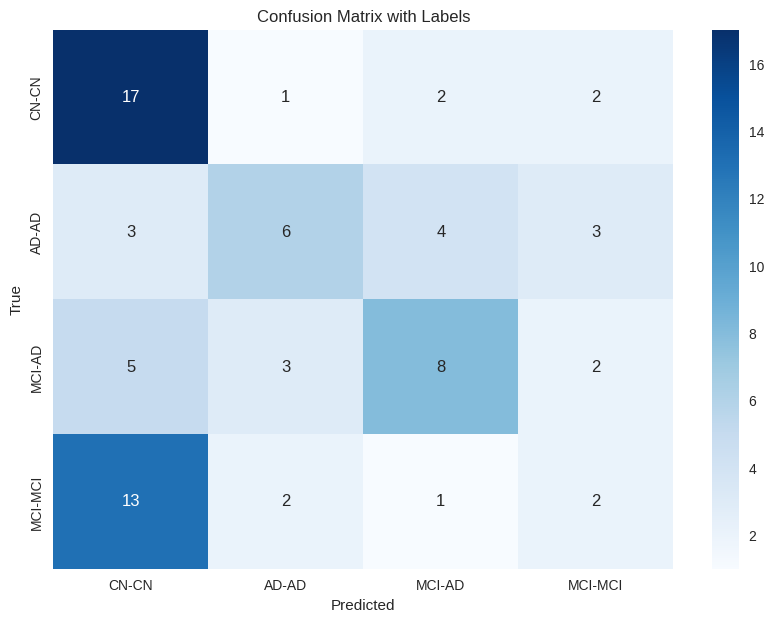

0.44594594594594594


In [40]:
kn_model = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto')
kn_model.fit(X_train, y_train)
kn_pred = kn_model.predict(X_test)
print(classification_report(y_test,kn_pred))
cm = confusion_matrix(y_test,kn_pred)
plot_confusion_matrix_with_labels(cm,label_mapping)
plt.show
print(accuracy_score(y_test, kn_pred))

#### Extreme Gradient Boosting

              precision    recall  f1-score   support

           0       0.56      0.91      0.69        22
           1       0.57      0.50      0.53        16
           2       0.33      0.28      0.30        18
           3       0.22      0.11      0.15        18

    accuracy                           0.47        74
   macro avg       0.42      0.45      0.42        74
weighted avg       0.42      0.47      0.43        74



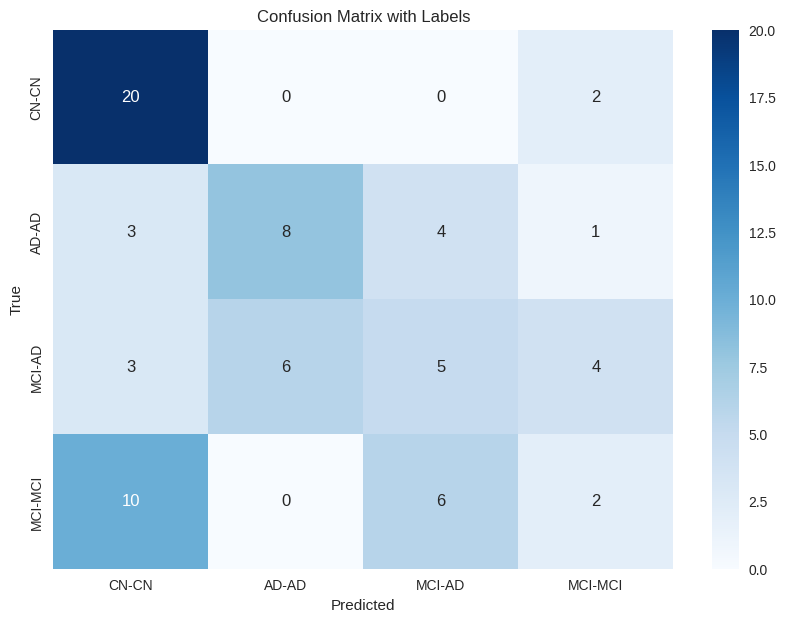

0.47297297297297297


In [41]:
xgb_model = XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.05,colsample_bytree=0.4, subsample=0.8, random_state=2022)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
print(classification_report(y_test,xgb_pred))
cm = confusion_matrix(y_test,xgb_pred)
plot_confusion_matrix_with_labels(cm,label_mapping)
plt.show
print(accuracy_score(y_test, xgb_pred))

In [42]:
# função que compara os modelos, para isso, usa um dicionário {"Model Name: [predictions], ..."}
def compare_models(Y_test, predictions):
    # Create a dictionary of models and their respective accuracies
    model_accuracies = {}
    for name, prediction in predictions.items():
        # Calculate the accuracy for each model
        accuracy = sum(prediction == Y_test) / len(Y_test)
        # Add the model and its accuracy to the dictionary
        model_accuracies[name] = accuracy

    # Sort the models by their accuracy in ascending order
    sorted_models = sorted(model_accuracies, key=model_accuracies.get)

    # Print the table with the accuracy of each model
    print("Model".ljust(20), "Accuracy")
    print("-" * 30)
    for model in sorted_models:
        print(model.ljust(20), str(model_accuracies[model]).rjust(10))


predictions = {
    'Random Forest Classifier' : rf_pred,
    'Extra Trees Classifier' : et_pred,
    'Gradient Boosting Classifier' : gb_pred,
    'K Neighbors Classifier' : kn_pred,
    'Extreme Gradient Boosting' : xgb_pred
}

compare_models(y_test, predictions)

Model                Accuracy
------------------------------
Gradient Boosting Classifier 0.4189189189189189
K Neighbors Classifier 0.44594594594594594
Random Forest Classifier 0.47297297297297297
Extreme Gradient Boosting 0.47297297297297297
Extra Trees Classifier 0.4864864864864865
